In [27]:
import numpy as np
import sys
import casadi

# Import do_mpc package:
import do_mpc

In [28]:
model_type = 'discrete' # either 'discrete' or 'continuous'
model = do_mpc.model.Model(model_type)

In [29]:
_x = model.set_variable(var_type='_x', var_name='x', shape=(4,1))
_u = model.set_variable(var_type='_u', var_name='u', shape=(1,1))

In [30]:
A = np.array([[ 0.763,  0.460,  0.115,  0.020],
              [-0.899,  0.763,  0.420,  0.115],
              [ 0.115,  0.020,  0.763,  0.460],
              [ 0.420,  0.115, -0.899,  0.763]])

B = np.array([[0.014],
              [0.063],
              [0.221],
              [0.367]])

x_next = A@_x + B@_u

model.set_rhs('x', x_next)

In [31]:
model.set_expression(expr_name='cost', expr=casadi.sum1(_x**2))

SX((((sq(x_0)+sq(x_1))+sq(x_2))+sq(x_3)))

In [32]:
# Build the model
model.setup()

In [33]:
mpc = do_mpc.controller.MPC(model)

In [34]:
setup_mpc = {
    'n_robust': 0,
    'n_horizon': 10,
    't_step': 0.5,
    'state_discretization': 'discrete',
    'store_full_solution':True,
    # Use MA27 linear solver in ipopt for faster calculations:
    #'nlpsol_opts': {'ipopt.linear_solver': 'MA27'}
}

mpc.set_param(**setup_mpc)

In [35]:
mterm = model.aux['cost'] # terminal cost
lterm = model.aux['cost'] # terminal cost
 # stage cost

mpc.set_objective(mterm=mterm, lterm=lterm)

mpc.set_rterm(u=1e-4) # input penalty

In [36]:
max_x = np.array([[4.0], [10.0], [4.0], [10.0]])

# lower bounds of the states
mpc.bounds['lower','_x','x'] = -max_x

# upper bounds of the states
mpc.bounds['upper','_x','x'] = max_x

# lower bounds of the input
mpc.bounds['lower','_u','u'] = -0.5

# upper bounds of the input
mpc.bounds['upper','_u','u'] =  0.5

In [37]:
mpc.setup()

In [38]:
estimator = do_mpc.estimator.StateFeedback(model)

In [39]:
simulator = do_mpc.simulator.Simulator(model)

In [40]:
simulator.set_param(t_step = 0.1)
simulator.setup()

In [41]:
# Seed
np.random.seed(99)

# Initial state
e = np.ones([model.n_x,1])
x0 = np.random.uniform(-3*e,3*e) # Values between +3 and +3 for all states
mpc.x0 = x0
simulator.x0 = x0
estimator.x0 = x0

# Use initial state to set the initial guess.
mpc.set_initial_guess()

In [42]:
%%capture
for k in range(50):
    u0 = mpc.make_step(x0)
    y_next = simulator.make_step(u0)
    x0 = estimator.make_step(y_next)

In [43]:
from matplotlib import rcParams
rcParams['axes.grid'] = True
rcParams['font.size'] = 18

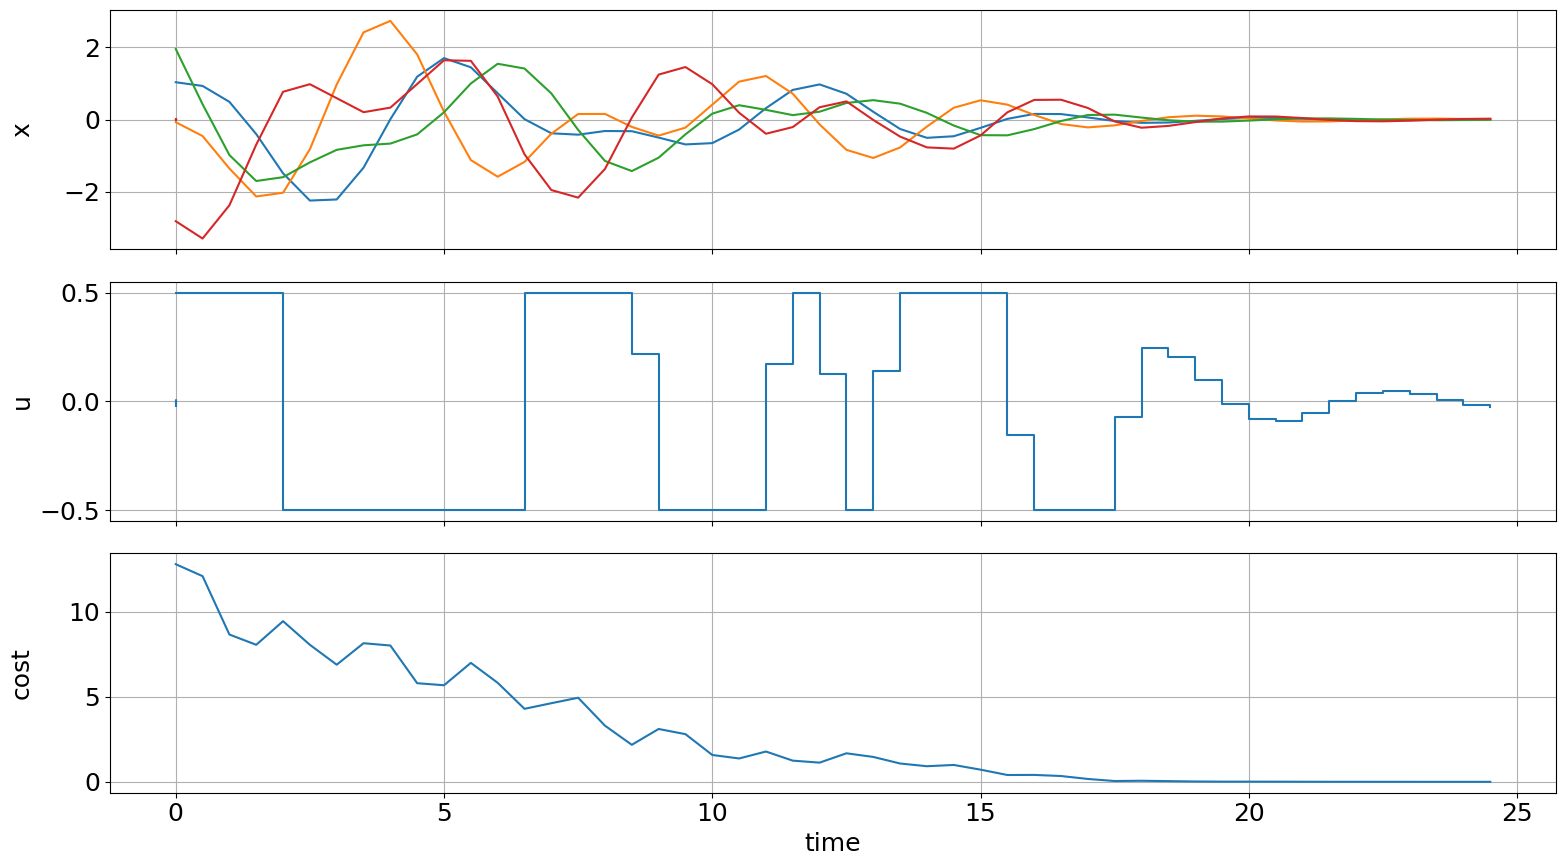

In [44]:
import matplotlib.pyplot as plt
fig, ax, graphics = do_mpc.graphics.default_plot(mpc.data, figsize=(16,9))
graphics.plot_results()
graphics.reset_axes()
plt.show()